In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""


import numpy as np
from openpiv import windef
from openpiv.test import test_process 
from openpiv import preprocess
import pathlib
import os
import matplotlib.pyplot as plt

frame_a, frame_b = test_process.create_pair(image_size=256)
shift_u, shift_v, threshold = test_process.shift_u, test_process.shift_v, \
                              test_process.threshold

# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

settings = windef.Settings()
settings.windowsizes = (64,)
settings.overlap = (32,)
settings.num_iterations = 1
settings.correlation_method = 'circular'
settings.sig2noise_method = 'peak2peak'
settings.subpixel_method = 'gaussian'
settings.sig2noise_mask = 2


# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_multi_pass_circ():
    """ test fot the multipass """
    settings.windowsizes = (64, 64, 16)
    settings.overlap = (32, 32, 8)
    settings.num_iterations = 2
    settings.interpolation_order = 3
    # ettings.show_all_plots = True

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    print("first pass\n")
    print("\n", x, y, u, v, s2n)
    assert np.allclose(u, shift_u, atol = threshold)
    assert np.allclose(v, shift_v, atol = threshold)

    if settings.image_mask:
        image_mask = np.logical_and(mask_a, mask_b)
        mask_coords = preprocess.mask_coordinates(image_mask)
        # mark those points on the grid of PIV inside the mask
        grid_mask = preprocess.prepare_mask_on_grid(x,y,mask_coords)

        # mask the velocity
        u = np.ma.masked_array(u, mask=grid_mask)
        v = np.ma.masked_array(v, mask=grid_mask)
    else:
        mask_coords = []
        u = np.ma.masked_array(u, mask=np.ma.nomask)
        v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1,settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings
        )

    print(f"Pass {i}\n")
    print(x)
    print(y)
    print(u) 
    print(v)
    print(s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    settings.correlation_method = 'linear'

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


def test_invert_and_piv():
    """ Test windef.piv with invert option """

    settings = windef.Settings()
    'Data related settings'
    # Folder with the images to process
    settings.filepath_images = '../data/test1'
    settings.save_path = '.'
    # Root name of the output Folder for Result Files
    settings.save_folder_suffix = 'test'
    # Format and Image Sequence
    settings.frame_pattern_a = 'exp1_001_a.bmp'
    settings.frame_pattern_b = 'exp1_001_b.bmp'

    settings.num_iterations = 1
    settings.show_plot = False
    settings.scale_plot = 100
    settings.show_all_plots = True
    settings.invert = True

    windef.piv(settings)


def test_multi_pass_lin():
    """ test fot the multipass """
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.num_iterations = 1
    settings.sig2noise_validate = True
    settings.correlation_method = 'linear'
    settings.normalized_correlation = True
    settings.sig2noise_method = 'peak2peak'
    settings.sig2noise_threshold = 1.0
    

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )

    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


    mask_coords = []
    u = np.ma.masked_array(u, mask=np.ma.nomask)
    v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1, settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings,
        )
        print(f"Iteration {i}")
        print("\n", x, y, u, v, s2n)
        assert np.allclose(u, shift_u, atol=threshold)
        assert np.allclose(v, shift_v, atol=threshold)

    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


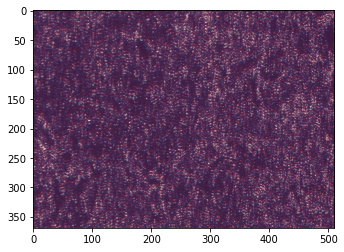

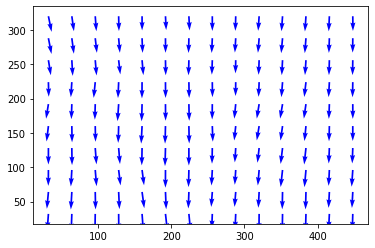

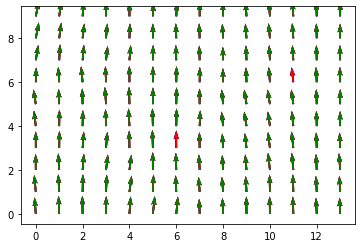

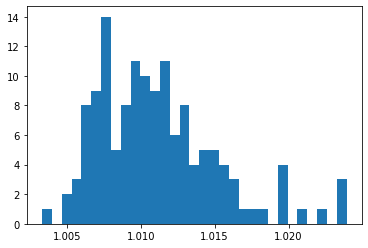

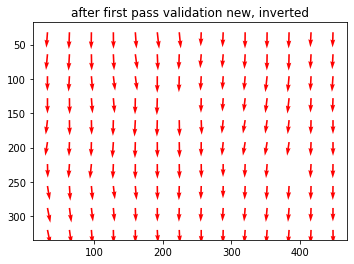

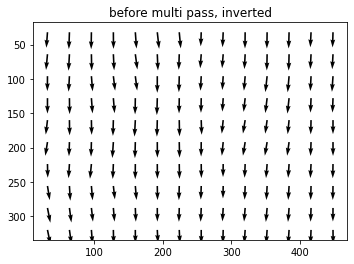

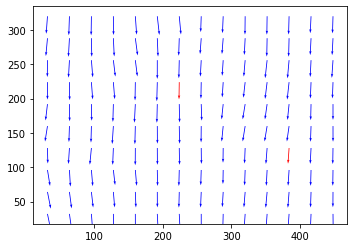

Image Pair 1
c:\Users\alex\repos\openpiv-python\openpiv\data\test1\exp1_001_a.bmp c:\Users\alex\repos\openpiv-python\openpiv\data\test1\exp1_001_b.bmp


In [4]:
test_invert_and_piv()

In [11]:
x, y, u, v, s2n = windef.first_pass(
    frame_a,
    frame_b,
    settings,
)

# print("\n", x, y, u, v, s2n)

In [6]:
from openpiv.validation import sig2noise_val

u, v, mask_s2n = sig2noise_val(
            u, v, s2n,
            threshold=settings.sig2noise_threshold
        )

In [8]:
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates

u, v, s2n = extended_search_area_piv(
    frame_a,
    frame_b,
    window_size=settings.windowsizes[0],
    overlap=settings.overlap[0],
    search_area_size=settings.windowsizes[0],
    width=settings.sig2noise_mask,
    subpixel_method=settings.subpixel_method,
    sig2noise_method=settings.sig2noise_method,
    correlation_method=settings.correlation_method,
    normalized_correlation=settings.normalized_correlation
)

shapes = np.array(get_field_shape(frame_a.shape,
                                  settings.windowsizes[0],
                                  settings.overlap[0]))
u = u.reshape(shapes)
v = v.reshape(shapes)
s2n = s2n.reshape(shapes)

x, y = get_coordinates(frame_a.shape,
                       settings.windowsizes[0],
                       settings.overlap[0])

# return x, y, u, v, s2n

In [54]:
def test_static_masking():
    """ Test windef.piv with invert option """

    settings = windef.Settings()
    'Data related settings'
    # Folder with the images to process
    # settings.filepath_images = pathlib.Path(__file__).parent / '../data/test2'
    settings.filepath_images = 'c:/users/alex/repos/openpiv-python/openpiv/data/test2'
    settings.save_path = '.'
    # Root name of the output Folder for Result Files
    settings.save_folder_suffix = 'test'
    # Format and Image Sequence
    settings.frame_pattern_a = '2image_*.tif'
    settings.frame_pattern_b = '(1+2),(3+4)'

    settings.static_masking = True
    settings.static_mask =  np.logical_or((a[:,:,0] > 220),(a[:,:,0] < 20))

    settings.num_iterations = 1
    settings.show_plot = False
    settings.scale_plot = 100
    settings.show_all_plots = False
    settings.invert = True

    windef.piv(settings)

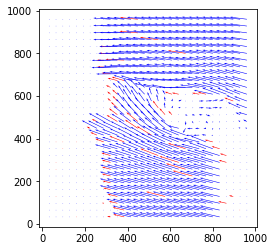

Image Pair 1
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_00.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_01.tif


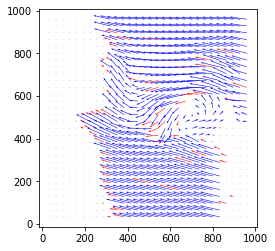

Image Pair 2
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_10.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_11.tif


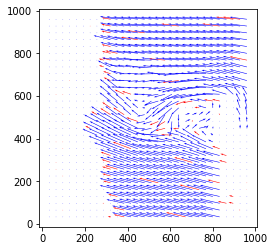

Image Pair 3
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_20.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_21.tif


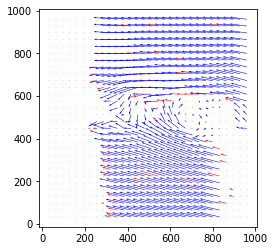

Image Pair 4
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_30.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_31.tif


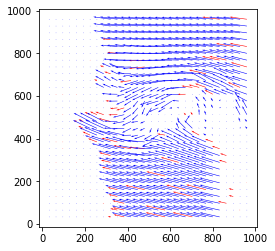

Image Pair 5
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_40.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_41.tif


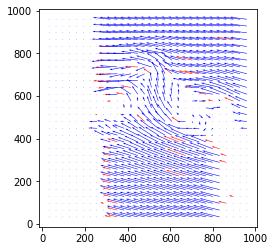

Image Pair 6
c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_50.tif c:\users\alex\repos\openpiv-python\openpiv\data\test2\2image_51.tif


In [55]:
test_static_masking()